# EMG data processing and classification.

EMG is electromyography, procedure used to obtain myoelectric data. This are recording of signals used by motor neurons to cause muscles to contratc (more information [here](https://www.mayoclinic.org/tests-procedures/emg/about/pac-20393913)).

This signals are frequently used in bionic prosthetics development. More information on myoelectric pattern recognition for bionic upper limb prosthetics [here](https://bionicsforeveryone.com/myoelectric-pattern-recognition-bionic-arms-hands/).

More references and sources are available in [README](../README.md).

Special Thanks go to [BioPatRec](https://github.com/biopatrec/biopatrec/wiki/BioPatRec.md) team for making EMG data sets available for free access on the web.

## Preparations.

Installing and importing required libraries.

In [64]:
# ! pip3 install numpy matplotlib scipy sklearn
! pip3 install pandas

  Using cached https://files.pythonhosted.org/packages/44/d9/fa9cb383b482b574e6926eabc437fe57b59908a7ed940612c8c308471872/pandas-1.3.5-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d3/e3/d9f046b5d1c94a3aeab15f1f867aa414f8ee9d196fae6865f1d6a0ee1a0b/pytz-2021.3-py2.py3-none-any.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [65]:
import math
import numpy as np
import scipy as sp
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt

# These are for the AI part:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Helper functions.

In [3]:
def plot_signal_amplitude_spectrum(s, time, signal_name, Fd):
    # Signal in Time domain
    fig, axs = plt.subplots(2, 1, figsize=(10, 7))
    axs[0].plot(time, s)
    axs[0].set(xlabel='Time, s', ylabel='Voltage, mV')
    
    # Amplitude spectrum 
    signal_fft = np.fft.fft(s)
    N = len(signal_fft)
    n = np.arange(N)
    T = N/Fd
    freq = n/T 
    axs[1].stem(freq, np.abs(signal_fft), linefmt='b', basefmt="-b")
    axs[1].set(xlabel='Frequency, Hz', ylabel='Amplitude')
    plt.xlim(-1, Fd/2)
    plt.suptitle(signal_name)
    plt.plot()

def plot_multiple_channel_signal(sig, time, signal_name, image_name="img", save_image=False):
    channels = len(sig)
    fig, axs = plt.subplots(channels, 1, figsize=(14, channels*6))
    
    for i in range(channels):
        axs[i].plot(time, sig[i])
        axs[i].set(xlabel='Time, s', ylabel='Voltage, mV', title=f'Channel {i+1}')

    plt.suptitle(signal_name)
    plt.show()
    
    if save_image:
        fig.set_size_inches(w=14,h=channels*6)
        fig.savefig(image_name+".png", facecolor="lightgray") 

### Downloading an EMG dataset.

In this project I will use data, provided by [BioPatRec](https://github.com/biopatrec/biopatrec).

To be precise, I will use data from this dataset: https://github.com/biopatrec/biopatrec/tree/Data_Repository/10mov4chForearmUntargeted.

(Part of the) info on dataset from https://github.com/biopatrec/biopatrec/wiki/Data_Repository.md:

* 10 hand and wrist motions: Hand Open/Close, Wrist Flex/Extend, Pro/Supination, Fine/Side Grip, Pointer (index extension), Agree or Thumb up
* 3 seconds contraction time with 3 seconds for relaxation between each repetition
* 3 repetitions of each motion
* 4 bipolar electrodes (Disposable Ag/AgCl)
* 20 subjects (final release)
    
* Amplifiers:
    * In-house design (MyoAmpF2F4-VGI8)
    * CMRR > 130 dB
    * Gain 71 dB
    * Embedded active ﬁltering:
        * 4th order high-pass ﬁlter at 20 Hz
        * 2nd order low-pass ﬁlter at 400 Hz
        * Notch ﬁlter at 50 Hz.
    * Galvanic isolation rated to 1,500 Vrms
* Signals were digitized at 2 kHz with a 14-bits resolution.

You can download one file using:

In [ ]:
!wget https://github.com/biopatrec/biopatrec/blob/Data_Repository/10mov4chForearmUntargeted/2.mat

**test_data.mat** is actually a renamed 2.mat, so its source is https://github.com/biopatrec/biopatrec/blob/Data_Repository/10mov4chForearmUntargeted/2.mat.

But, the whole dataset is available in this repository as an archive (it was downloaded from https://github.com/biopatrec/biopatrec/tree/Data_Repository/10mov4chForearmUntargeted). 

Now we will unzip it:

In [307]:
!unzip -q biopatrec_10mov4chForearmUntargeted.zip

### Reading data from the data set.

Example of data in one file:

In [8]:
# Load Recording session data from the file
filename = "test_data.mat"
mat = loadmat(filename)
rec_session = mat['recSession']

# Load information from recording session
sF = rec_session['sF'][0][0][0][0]
sT = rec_session['sT'][0][0][0][0]
tdata = rec_session['tdata'][0][0]
nCh = rec_session['nCh'][0][0][0][0]
dev = rec_session['dev'][0][0][0][0][0]
mov_labels = [el[0][0] for el in rec_session['mov'][0][0]]

# Extracting the movements from total data and saving them with according labels
movements_dictionary = dict()
for i in range(len(mov_labels)):
    movements_dictionary[mov_labels[i]] = tdata[:, :, i].transpose()

The dictionary with movements contains them in such arrangement: {'movement name':array(channel 1, channel 2, channel 3, channel 4), ...}

Each channel has with 36000 signal samples (for the file I am currently using).

In [9]:
print("Info about data:")
print(f"\tsampling frequency = {sF} Hz") 
print(f"\tsampling time = {sT} s")
print(f"\tnumber of channels = {nCh}")
print(f"\tsignal recording devise: {dev}")
print("Data contains such movements, as", mov_labels)

Info about data:
	sampling frequency = 2000 Hz
	sampling time = 18 s
	number of channels = 4
	signal recording devise: MyoAmpF4F2
Data contains such movements, as ['Open Hand', 'Close Hand', 'Flex Hand', 'Extend Hand', 'Pronation', 'Supination', 'Side Grip', 'Fine Grip', 'Agree', 'Pointer']


Reading the whole dataset:

In [54]:
# For data
X = []
# For labels
y = []

for filename in os.listdir("./10mov4chForearmUntargeted"):
    if filename.endswith(".mat"): 
        # Reading recording session info from the mat files in the BioPatRec dataset
        mat = loadmat("./10mov4chForearmUntargeted/" + filename)
        rec_session = mat['recSession']
        
        # Sampling frequecy
        sF = rec_session['sF'][0][0][0][0]
        # Sampling time
        sT = rec_session['sT'][0][0][0][0]
        # Total data
        tdata = rec_session['tdata'][0][0]
        # Labels for the data
        mov_labels = [el[0][0] for el in rec_session['mov'][0][0]]
        
        time = np.arange(0, sT, 1/sF) 
        for i in range(len(mov_labels)):
            # Reorganizing matrix, so it is easier to work with four channels
            four_channel_data = tdata[:, :, i].transpose()

            # Concatenating four channel into one vector with data and saving it in the vector for data
            # X.append(np.concatenate(processed_four_channel_data))
            
            # Adding each channel separately to the vector for data
            X.extend([channel for channel in four_channel_data])
            
            # Adding channels in an array to the vector for data
            # X.append(four_channel_data)
        
        # Saving labels (they will be 0, 1, 2, ... 9 for the 10 available movements, accordingly)
        # y.extend([i for i in np.arange(10)])
        
        # Saving labels (they will be 0, 1, 2, ... 9 for the 10 available movements, accordingly), 
        # but repeating them for each channel
        y.extend([[i]*4 for i in np.arange(10)])
        continue
    else:
        continue
        
y = np.concatenate(y)

In [55]:
print("Number of all recordings:", len(y))
# print("Number of complete 4-channel signals:", int(len(y)/4))

Number of all recordings: 800


# I Signal Processing: EMG data processing.

Signal processing pipeline structure is based on the tutorial from https://scientificallysound.org/2016/08/22/python-analysing-emg-signals-part-4/.

This dataset already contains some preprocessing (4th order high-pass ﬁlter at 20 Hz, 2nd order low-pass ﬁlter at 400 Hz, Notch ﬁlter at 50 Hz), but this is not a complete processing, required for EMG data. 

Processing pipeline will include:
1. Removing mean EMG (making average 0 volts)
2. Rectification (using absolute values of the signal)
3. Butterworth low-pass filter for envelope

In [49]:
def processing_pipeline(sig, time, sF, name="", envelope_low_pass_fr=1, visualize=False):
    """
    Pipeline for signals with multiple channels.
    """
    
    if visualize:
        plot_multiple_channel_signal(sig, time, f'Raw signal: {name}', "1", False)
        
    # Removing mean EMG (making average 0 volts)
    for i in range(len(sig)):
        sig[i] -= np.mean(sig[i])
    
    if visualize:
        plot_multiple_channel_signal(sig, time, f'Zero-average signal: {name}', "2", False)
        
    # Rectification (using absolute values of the signal)
    rectified_signal = []
    for i in range(len(sig)):
        rectified_signal.append(abs(sig[i]))
    
    if visualize:
        plot_multiple_channel_signal(rectified_signal, time, f'Rectified signal: {name}', "3", False)
        
    # Butterworth low-pass filter for envelope
    low_pass_fr = envelope_low_pass_fr/(sF/2)
    b, a = sp.signal.butter(4, low_pass_fr, btype='lowpass')
    final_sig = sp.signal.filtfilt(b, a, rectified_signal)
    
    if visualize:
        plot_multiple_channel_signal(final_sig, time, f'Envelope: {name}', "4", False)
    
    return final_sig

## Processing each signal from the dataset.

In [50]:
for signal_index in range(len(X)):
    # Applying signal processing pipeline to EMG signals
    X[signal_index] = processing_pipeline(X[signal_index], time, sF, visualize=False)

KeyboardInterrupt: 

## Data analysis and visualizations.

Here is an example visualization of a 'Fine Grip' movement (for all 4 channels).

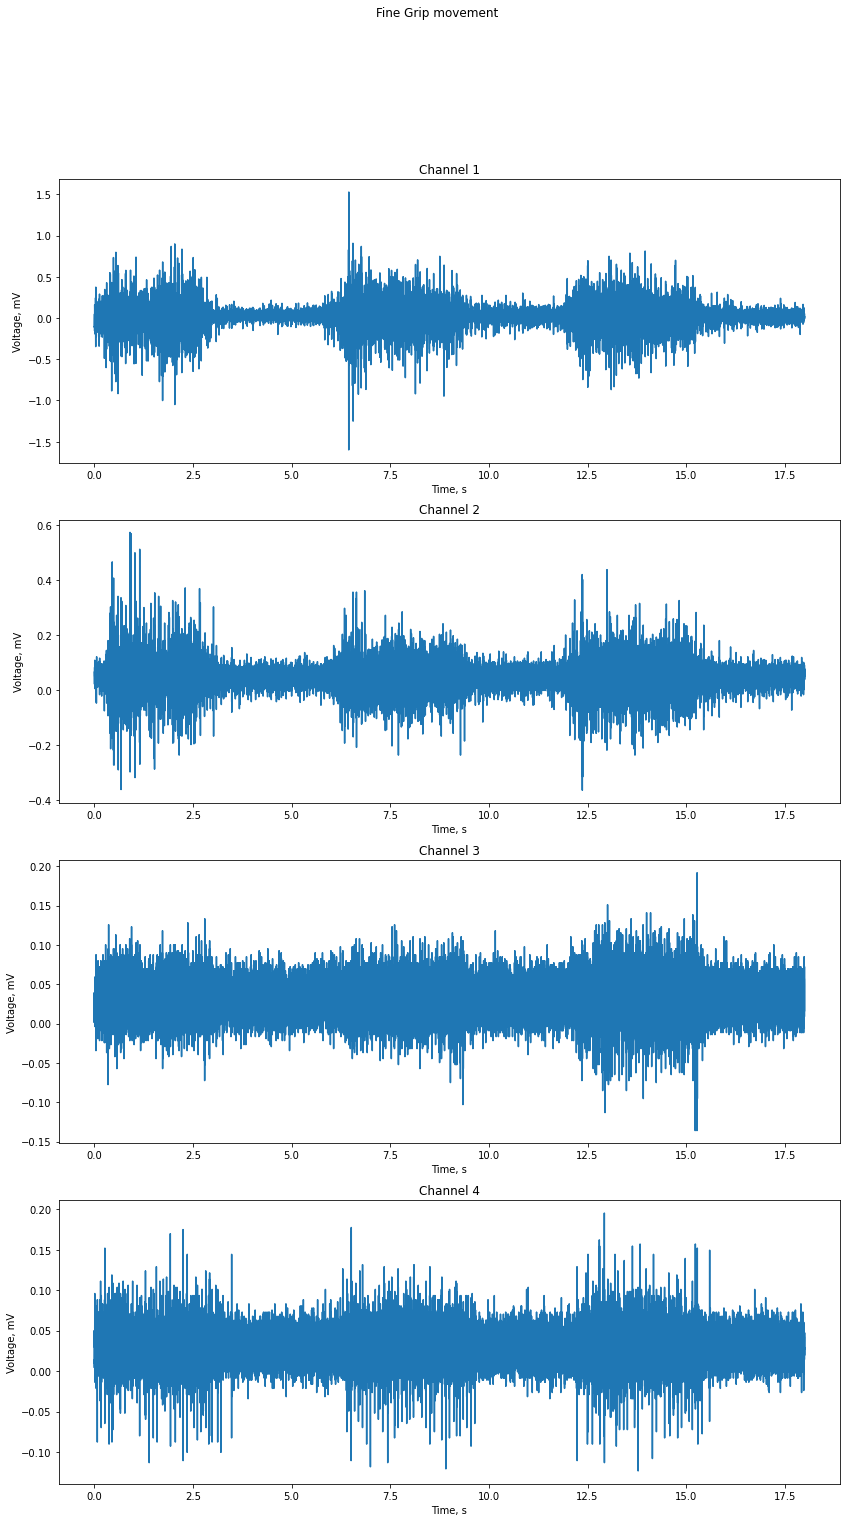

In [28]:
time = np.arange(0, sT, 1/sF)
plot_multiple_channel_signal(movements_dictionary['Fine Grip'], time, 'Fine Grip movement')

Amplitude spectrum for Fine Grip movement (on one channel).

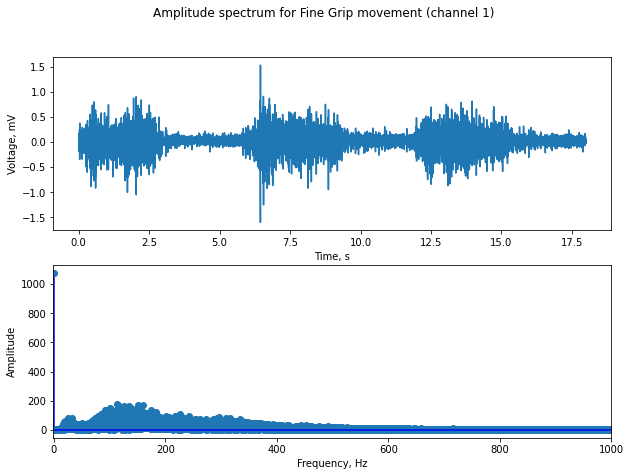

In [29]:
plot_signal_amplitude_spectrum(movements_dictionary['Fine Grip'][0], time, 'Amplitude spectrum for Fine Grip movement (channel 1)', sF)

Spectrogram for better understanding of the data.

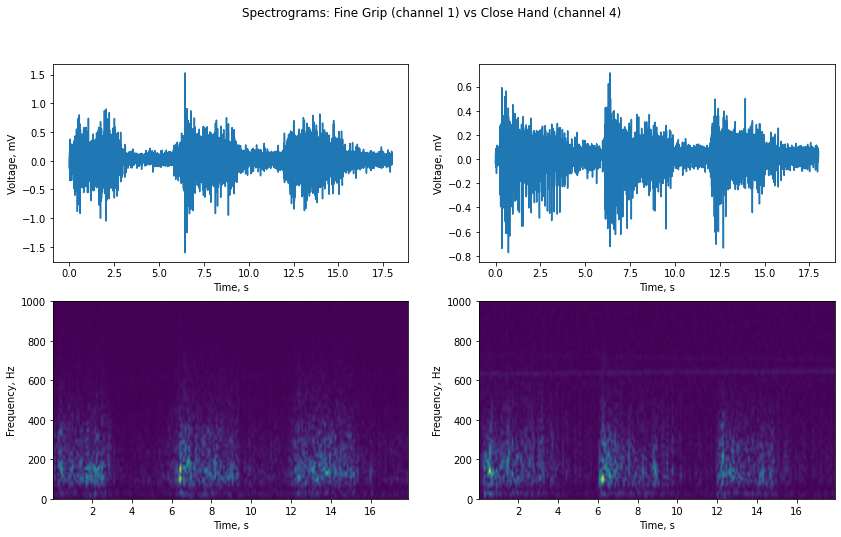

In [30]:
sig = movements_dictionary['Fine Grip'][0]
window = sp.signal.windows.blackmanharris(math.floor(0.1*sF))

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0, 0].plot(time, sig)
axs[0, 0].set(xlabel='Time, s', ylabel='Voltage, mV')

f, t, Sxx = sp.signal.spectrogram(sig, fs=sF, window=window, noverlap=None, mode='magnitude')
axs[1, 0].pcolormesh(t, f, Sxx, shading='gouraud')
axs[1, 0].set(xlabel='Time, s', ylabel='Frequency, Hz')

sig = movements_dictionary['Close Hand'][3]
axs[0, 1].plot(time, sig)
axs[0, 1].set(xlabel='Time, s', ylabel='Voltage, mV')

f, t, Sxx = sp.signal.spectrogram(sig, fs=sF, window=window, noverlap=None, mode='magnitude')
axs[1, 1].pcolormesh(t, f, Sxx, shading='gouraud')
axs[1, 1].set(xlabel='Time, s', ylabel='Frequency, Hz')

plt.suptitle("Spectrograms: Fine Grip (channel 1) vs Close Hand (channel 4)")
plt.show()

It is easy to spot that there are three repetitions of each movement.

Saving image:

In [407]:
fig_name = 'spectrograms.png'
fig.set_size_inches(w=14,h=8)
fig.savefig(fig_name, facecolor="lightgray")

Visualization of the signal processing pipeline on signal for Fine Grip movement.

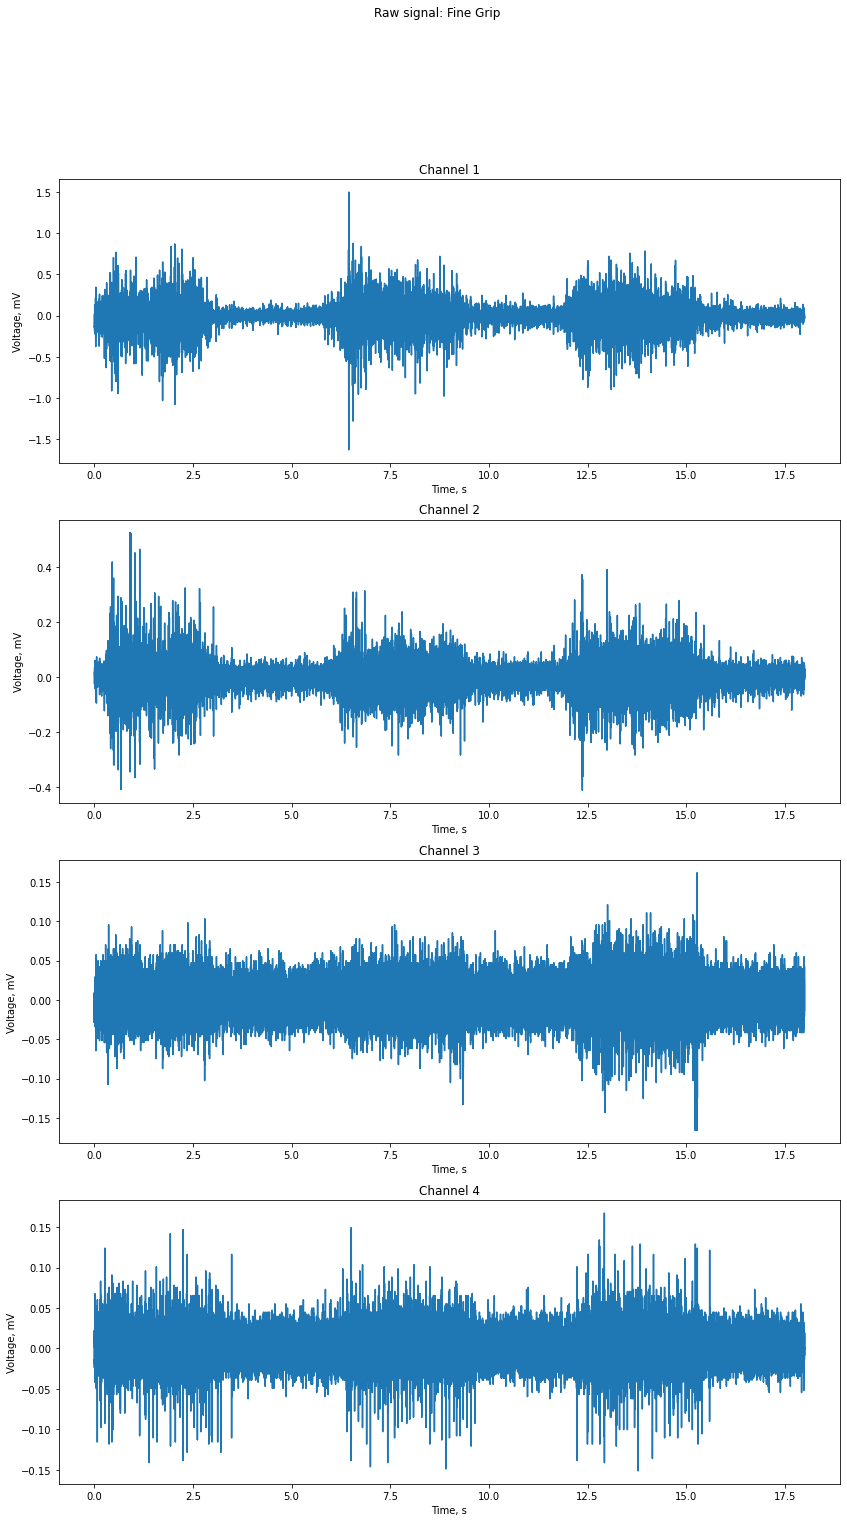

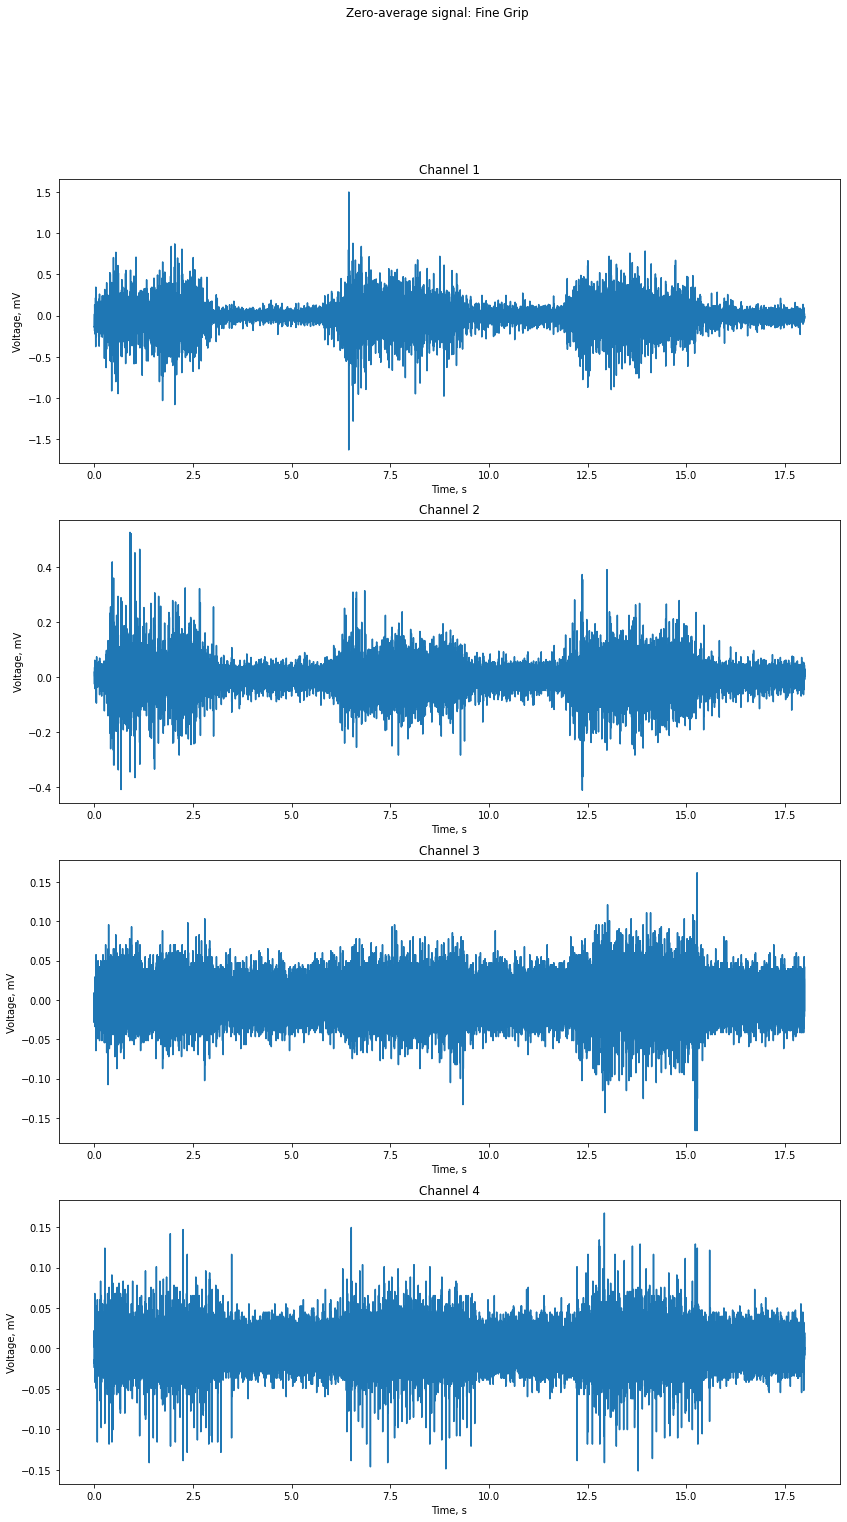

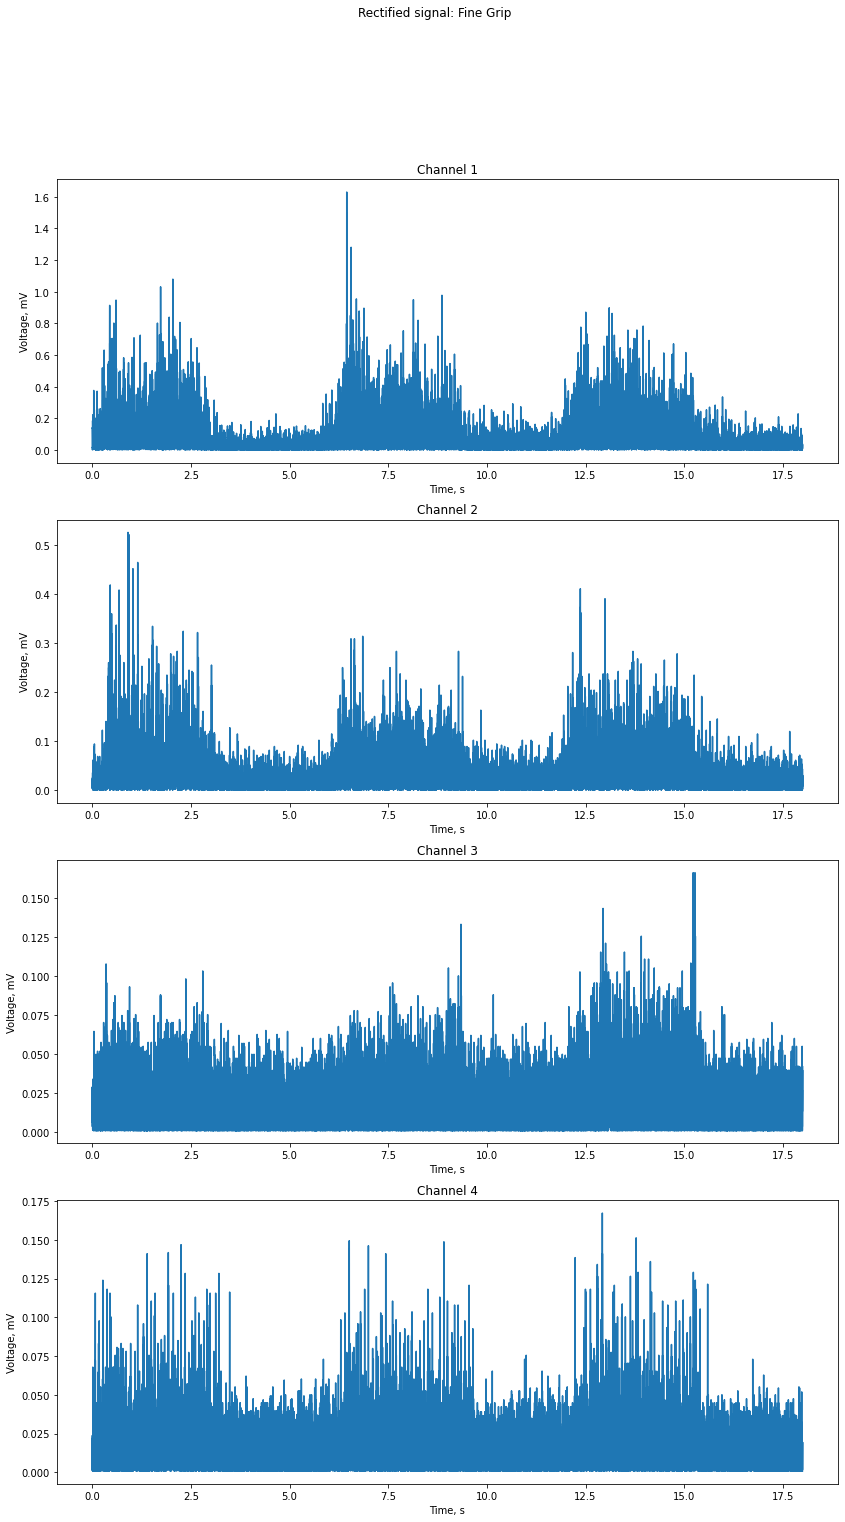

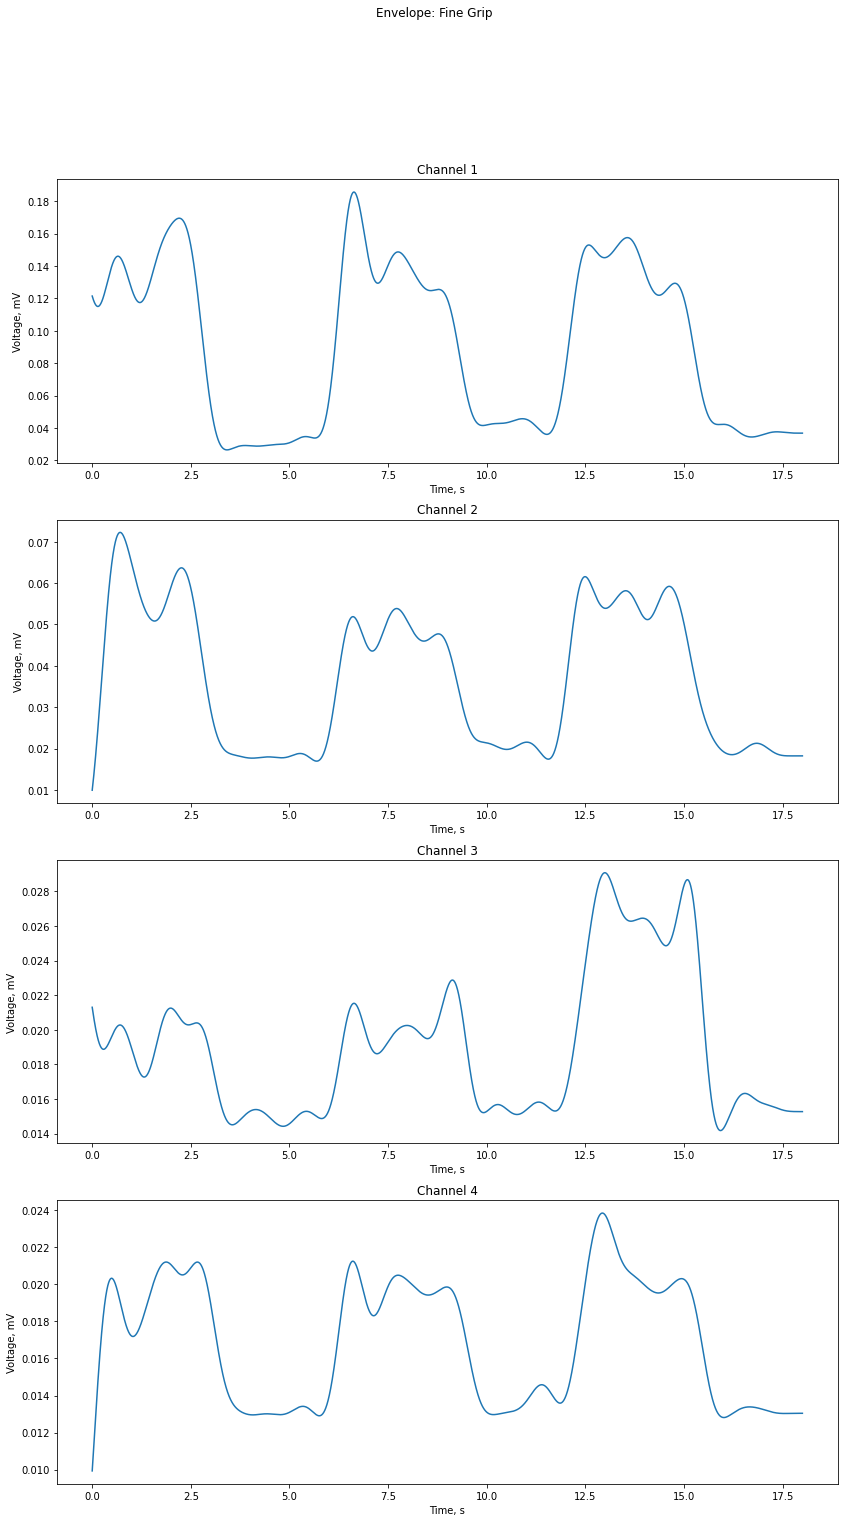

In [37]:
time = np.arange(0, sT, 1/sF) 
test_signal = movements_dictionary['Fine Grip']
_ = processing_pipeline(test_signal, time, sF, 'Fine Grip', 1, visualize=True)

Here is visualization of Open Hand movement processing for comparison.

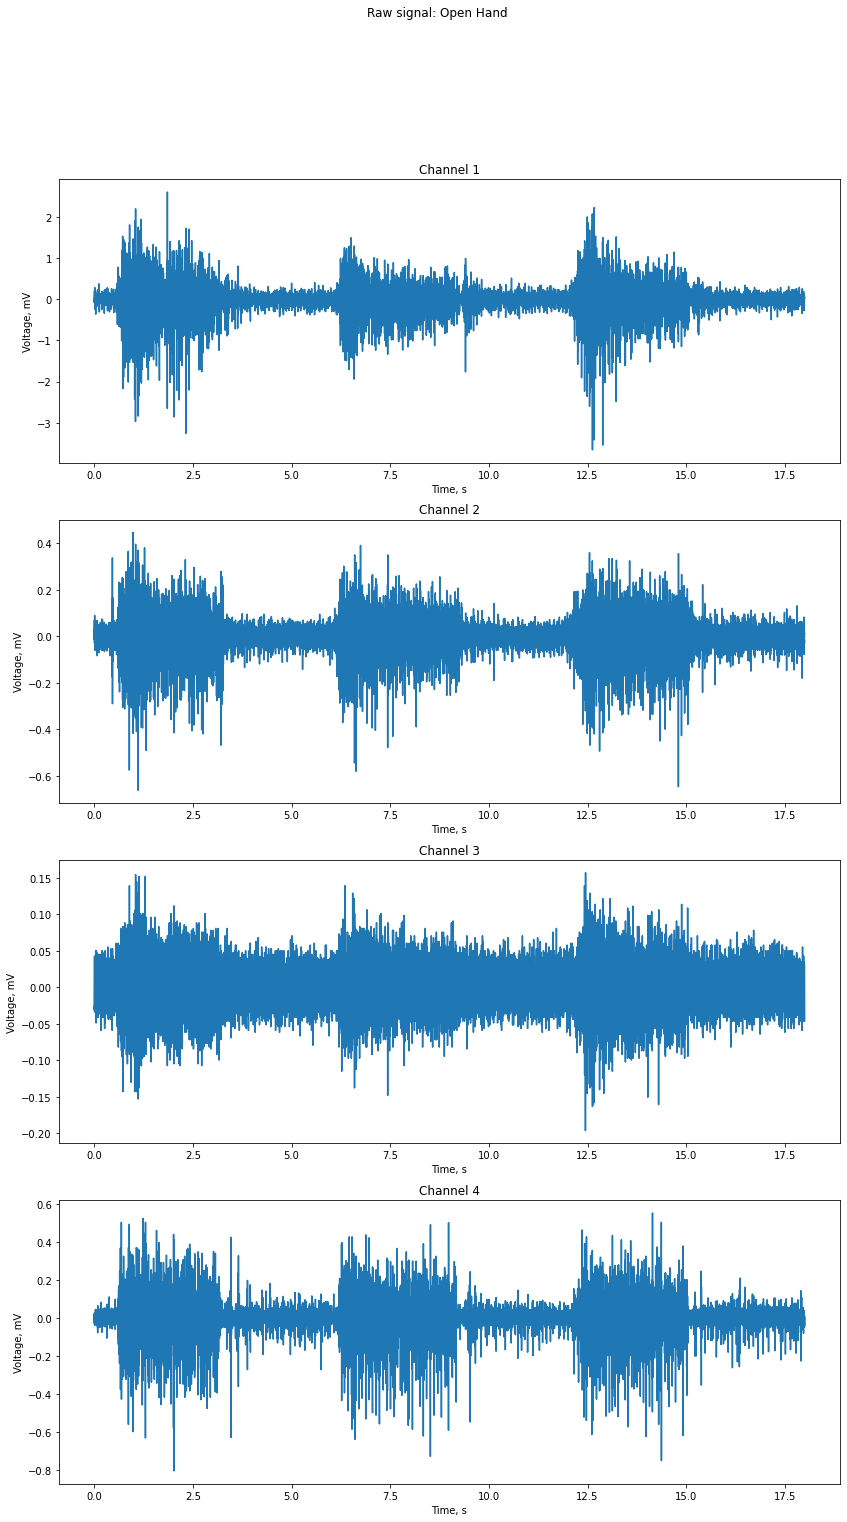

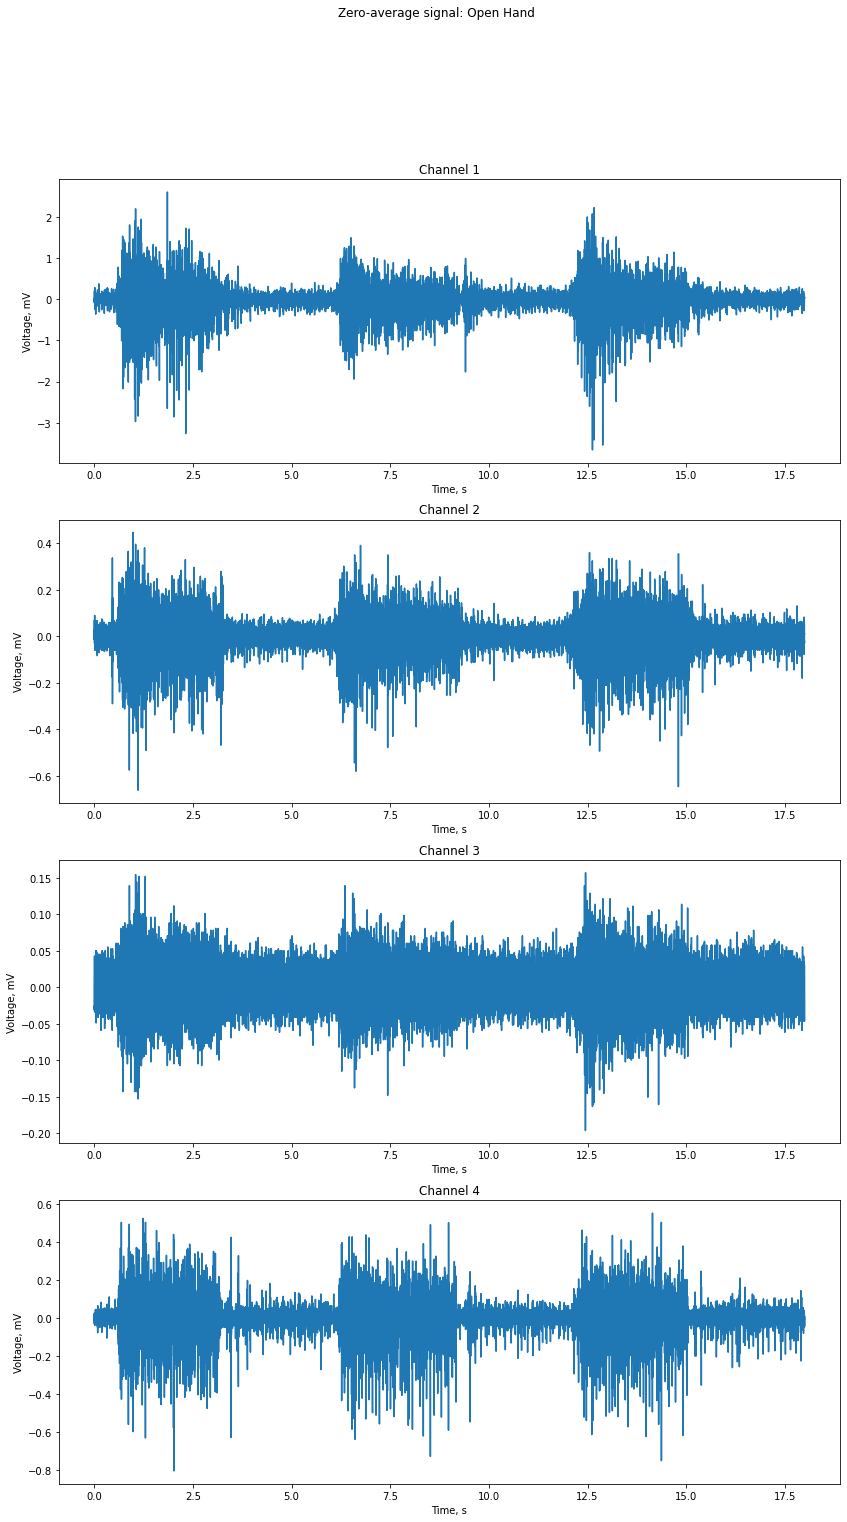

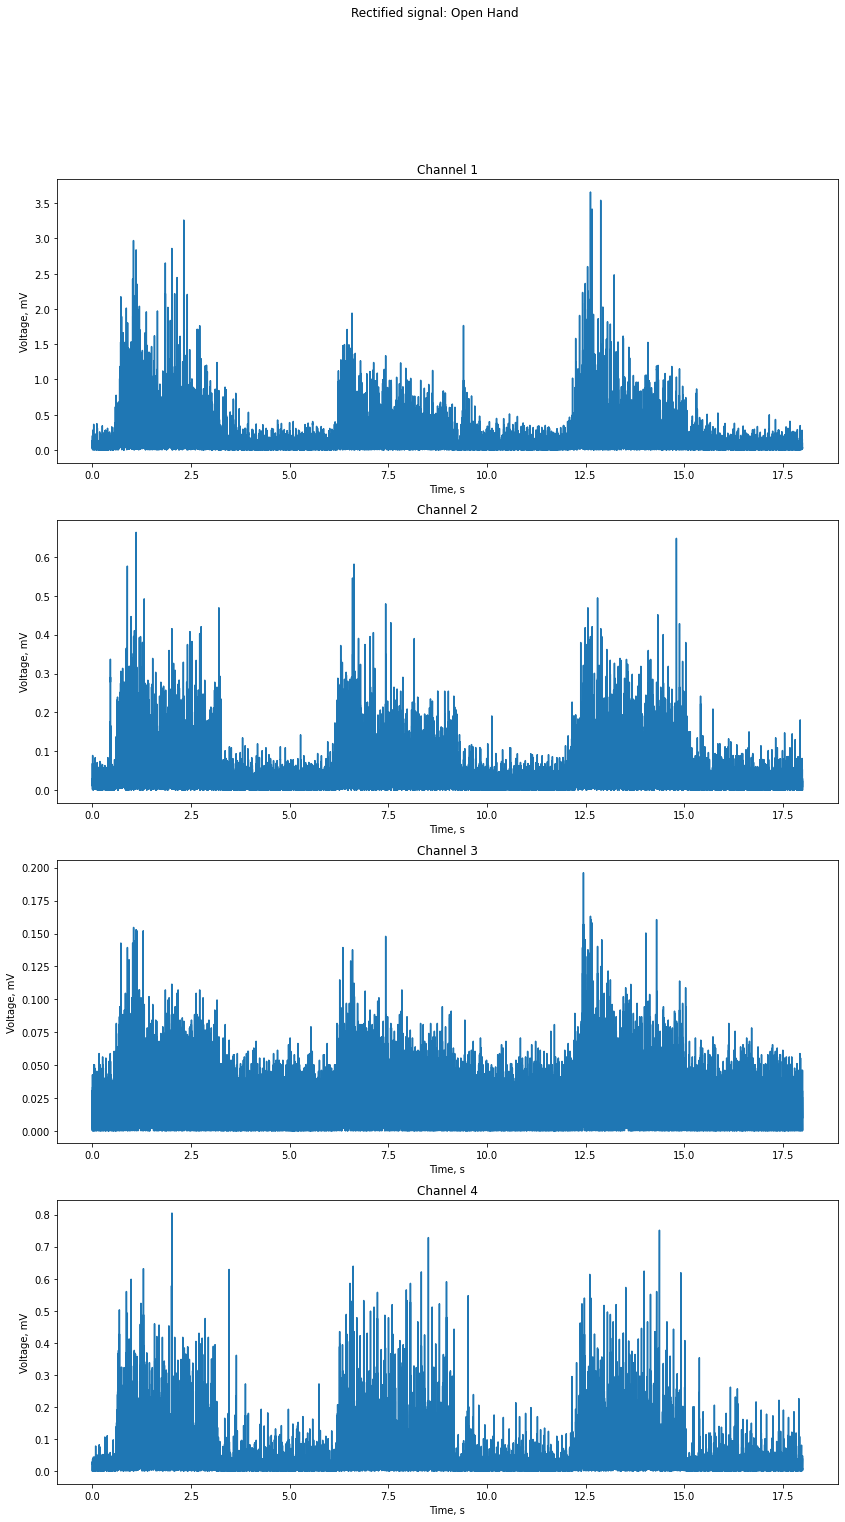

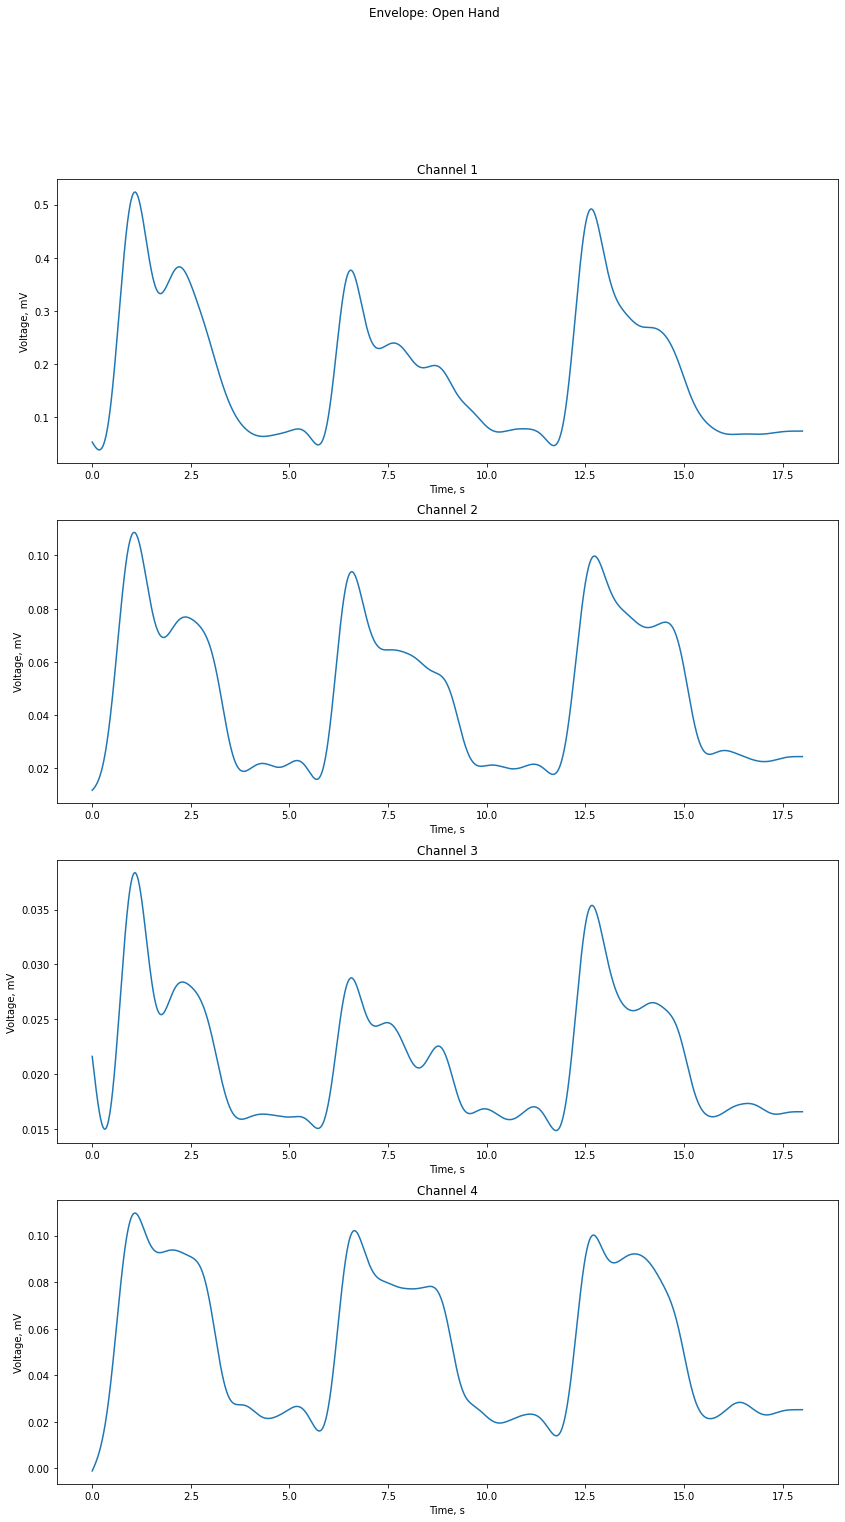

In [38]:
time = np.arange(0, sT, 1/sF) 
test_signal = movements_dictionary['Open Hand']
_ = processing_pipeline(test_signal, time, sF, 'Open Hand', 1, visualize=True)

Visual comparison of signals for different movements in order to see which channel is the most important in order to see the difference between movements:

In [39]:
todo

NameError: name 'todo' is not defined

# II AI: Movement classification.

## Feature extraction for classification.

In [40]:
todo

NameError: name 'todo' is not defined

## Classification.

Custom metrics functions:

In [91]:
def metrics(y_test, y_predicted, name):
    print(f"Accuracy of the {name} model:", sklearn.metrics.accuracy_score(y_test, y_predicted))
    print("Confusion matrix:")
    return confusion_matrix(y_test, y_predicted)

def confusion_matrix(y_actual, y_predicted):
    confusion_matrix = pd.crosstab(pd.Series(y_actual, name='Actual'), pd.Series(y_predicted, name='Predicted'))
    confusion_matrix = confusion_matrix.set_axis(mov_labels, axis=1)
    confusion_matrix = confusion_matrix.set_axis(mov_labels, axis=0)
    return confusion_matrix

### k-folds cross-validation.

In [ ]:
todo

Creating training and testing loaders.

In [56]:
class training_set(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = X                           
        self.Y = Y                           

    def __len__(self):
        return len(self.X)                   

    def __getitem__(self, idx):
        return [torch.from_numpy(self.X[idx].copy()), self.Y[idx]]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

training_dataset = training_set(X_train, y_train)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=50, shuffle=True)
print("Size of Training dataset:", len(training_dataset))

testing_dataset = training_set(X_test, y_test)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=50, shuffle=True)
print("Size of Testing dataset:", len(testing_dataset))

Size of Training dataset: 720
Size of Testing dataset: 80


Using the processed signal data, I will create a classification model to recognize available movements.

### Using Decision Tree Classifier.

Here I will use an algorithm from sklearn library.

In [78]:
dtree_model = DecisionTreeClassifier(max_depth = 20).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

In [92]:
metrics(y_test, dtree_predictions, "Decision Tree")

Accuracy of the Decision Tree model: 0.15
Confusion matrix:


,Open Hand,Close Hand,Flex Hand,Extend Hand,Pronation,Supination,Side Grip,Fine Grip,Agree,Pointer
Open Hand,1,1,1,0,0,3,0,0,0,0
Close Hand,1,3,3,0,2,0,1,0,0,0
Flex Hand,0,0,2,2,1,0,1,2,0,1
Extend Hand,2,0,0,0,1,2,0,1,2,0
Pronation,1,0,0,1,0,2,0,2,1,0
Supination,0,1,1,0,3,2,0,2,0,0
Side Grip,0,0,1,2,1,2,1,1,3,0
Fine Grip,0,1,0,0,0,1,1,1,0,0
Agree,1,0,1,0,0,0,1,2,1,1
Pointer,2,1,0,1,0,1,1,1,1,1


Currently, accuracy differs each time, the best was 0.3 (which is not good).

### Using SVM

In [80]:
svm_model_linear = SVC(kernel = 'linear').fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)

In [93]:
metrics(y_test, svm_predictions, "SVM")

Accuracy of the SVM model: 0.4375
Confusion matrix:


,Open Hand,Close Hand,Flex Hand,Extend Hand,Pronation,Supination,Side Grip,Fine Grip,Agree,Pointer
Open Hand,1,0,1,0,0,0,2,2,0,0
Close Hand,0,2,1,0,0,1,1,2,1,2
Flex Hand,0,0,6,0,0,1,0,2,0,0
Extend Hand,1,0,0,4,0,0,0,2,1,0
Pronation,1,0,0,0,2,0,0,1,1,2
Supination,0,0,0,0,0,4,2,2,0,1
Side Grip,0,0,1,0,0,0,6,3,1,0
Fine Grip,0,0,0,0,0,0,0,4,0,0
Agree,0,0,0,0,0,0,0,4,2,1
Pointer,0,0,0,0,0,0,1,4,0,4


### Using KNN (k-nearest neighbors) classifier

In [100]:
knn = KNeighborsClassifier(n_neighbors = 2).fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [101]:
metrics(y_test, knn_pred, "KNN")

Accuracy of the KNN model: 0.325
Confusion matrix:


,Open Hand,Close Hand,Flex Hand,Extend Hand,Pronation,Supination,Side Grip,Fine Grip,Agree,Pointer
Open Hand,2,0,0,0,0,0,0,4,0,0
Close Hand,1,1,0,1,0,0,1,6,0,0
Flex Hand,2,0,5,0,0,0,1,1,0,0
Extend Hand,0,0,0,6,0,0,0,2,0,0
Pronation,1,0,0,0,2,0,0,4,0,0
Supination,1,0,0,0,0,3,1,4,0,0
Side Grip,1,0,0,0,0,0,2,7,0,1
Fine Grip,0,0,0,0,0,0,0,4,0,0
Agree,1,0,0,0,0,0,0,5,1,0
Pointer,3,0,0,0,0,0,0,6,0,0


For KNN the best accuracy currently is 0.325.

### Using Naive Bayes classifier

In [102]:
gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)

In [103]:
metrics(y_test, gnb_predictions, "Naive Bayes classifier")

Accuracy of the Naive Bayes classifier model: 0.225
Confusion matrix:


,Open Hand,Close Hand,Flex Hand,Extend Hand,Pronation,Supination,Side Grip,Fine Grip,Agree,Pointer
Open Hand,1,0,0,1,0,2,1,0,1,0
Close Hand,1,0,1,1,1,0,3,1,0,2
Flex Hand,1,0,1,3,0,1,2,1,0,0
Extend Hand,0,0,1,2,0,0,2,2,0,1
Pronation,0,0,1,2,1,0,1,0,0,2
Supination,0,0,0,0,0,4,2,1,0,2
Side Grip,1,1,0,0,0,0,6,2,1,0
Fine Grip,0,0,0,0,0,0,3,1,0,0
Agree,0,0,0,0,0,2,4,0,0,1
Pointer,0,0,0,1,0,0,6,0,0,2


For Naive Bayes the best accuracy currently is 0.225.

### Using Neural Network.

Training an MLP (Multilayer Perceptron) model:

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self, initial_size):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(initial_size, 1000)
        self.layer_2 = nn.Linear(1000, 100)
        self.layer_3 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.layer_1(x.float())
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [105]:
model = MLP(initial_size = len(X[0])).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 20

model.train()
for epoch in range(epochs):
    losses = []
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x_var, y_var = input_data
        x_var = x_var.to(device).float()
        y_var = y_var.to(device)

        output = model(x_var)
        loss = criterion(output, y_var)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

        if batch_num % 40 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

	Epoch 0 | Batch 0 | Loss   2.30
Epoch 0 | Loss   2.77
	Epoch 1 | Batch 0 | Loss   1.36
Epoch 1 | Loss   1.31
	Epoch 2 | Batch 0 | Loss   1.03
Epoch 2 | Loss   0.80
	Epoch 3 | Batch 0 | Loss   0.54
Epoch 3 | Loss   0.45
	Epoch 4 | Batch 0 | Loss   0.16
Epoch 4 | Loss   0.22
	Epoch 5 | Batch 0 | Loss   0.17
Epoch 5 | Loss   0.10
	Epoch 6 | Batch 0 | Loss   0.07
Epoch 6 | Loss   0.04
	Epoch 7 | Batch 0 | Loss   0.03
Epoch 7 | Loss   0.02
	Epoch 8 | Batch 0 | Loss   0.02
Epoch 8 | Loss   0.01
	Epoch 9 | Batch 0 | Loss   0.01
Epoch 9 | Loss   0.01
	Epoch 10 | Batch 0 | Loss   0.00
Epoch 10 | Loss   0.01
	Epoch 11 | Batch 0 | Loss   0.01
Epoch 11 | Loss   0.00
	Epoch 12 | Batch 0 | Loss   0.00
Epoch 12 | Loss   0.00
	Epoch 13 | Batch 0 | Loss   0.00
Epoch 13 | Loss   0.00
	Epoch 14 | Batch 0 | Loss   0.00
Epoch 14 | Loss   0.00
	Epoch 15 | Batch 0 | Loss   0.00
Epoch 15 | Loss   0.00
	Epoch 16 | Batch 0 | Loss   0.00
Epoch 16 | Loss   0.00
	Epoch 17 | Batch 0 | Loss   0.00
Epoch 17 | Loss  

Model evaluation.

In [106]:
model.eval()
total_loss = 0
correct = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(testing_loader):
        output = model(data)
        loss = F.cross_entropy(output, target) 
        total_loss += loss.item()
        correct += (output.argmax(1) == target).type(torch.float).sum().item()
        show_output = output.argmax(1)
        # print(f"Expected   vs    Got")
        # for i in range(len(target)):
        #     print(mov_labels[target[i]], "   ", mov_labels[show_output[i]])

print('Testing: Epoch average loss {:.6f}'.format(total_loss/len(testing_loader.dataset)))
print(f"         Accuracy: {(100*(correct/len(testing_loader.dataset))):>0.1f}%")

Testing: Epoch average loss 0.095036
         Accuracy: 48.8%


In [125]:
final_prediction = model(torch.from_numpy(np.array(X_test)))
metrics(y_test, final_prediction.argmax(1), "Neural Network")

Accuracy of the Neural Network model: 0.4875
Confusion matrix:


,Open Hand,Close Hand,Flex Hand,Extend Hand,Pronation,Supination,Side Grip,Fine Grip,Agree,Pointer
Open Hand,1,0,0,0,0,0,2,2,1,0
Close Hand,0,4,0,1,0,1,0,1,1,2
Flex Hand,1,0,5,0,0,0,0,3,0,0
Extend Hand,0,0,0,6,1,0,0,1,0,0
Pronation,0,0,1,0,1,1,0,2,1,1
Supination,0,1,0,0,0,6,0,1,0,1
Side Grip,0,0,0,0,0,1,6,3,0,1
Fine Grip,0,0,0,0,0,0,0,3,0,1
Agree,0,0,0,0,0,0,1,3,3,0
Pointer,0,0,0,0,0,0,2,3,0,4


Even tho final accuracy of the model is low, we still can see, some of the movements, which were predicted wrongly, are a little similar to  expected movements.